## Import libraries

In [30]:
import sys, os
sys.path.append(os.path.abspath('../src'))

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import train


In [ ]:
# Import personalized modules
from train import (
    build_dense_model, build_rnn_model, build_lstm_model,
    train_model, grid_search_dense, bayes_opt_rnn, bayes_opt_lstm
)
from evaluate import evaluate_model
from visualize import (
    plot_training_history, plot_confusion_matrix,
    plot_roc_curve, plot_precision_recall, compare_training_histories, compare_metrics
)
from persist import (save_plot, save_trained_model)


## Load needed data

In [ ]:
print("Load preprocessed dataset...")
df = pd.read_csv("../data/processed/clean_reviews.csv")
print(f"Dataset loaded: {df.shape}")
print(df.head())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_sentence"], df["label"],
    test_size=0.2, random_state=42
)

Load preprocessed dataset...
Dataset loaded: (2727, 2)
                                      clean_sentence  label
0        aimless movie distressed drifting young man      0
1  sure lost flat character audience nearly half ...      0
2  attempting artiness black white clever camera ...      0
3                        little music anything speak      0
4  best scene movie gerardo trying find song keep...      1


In [ ]:
# --- Dense NN with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()
input_dim = X_train_tfidf.shape[1]

# --- RNN / LSTM with sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1

## 1. Dense neural network

In [61]:
# Training without optimization
print("\nTraining dense model (default parameters)...")
dense_default = build_dense_model(input_dim)
history_default = dense_default.fit(
    X_train_tfidf, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluation
dense_default_results = evaluate_model(dense_default, X_test_tfidf, y_test)
y_pred_default = (dense_default.predict(X_test_tfidf) > 0.5).astype(int)


Training dense model (default parameters)...
Epoch 1/10
55/55 [==============================] - 3s 14ms/step - loss: 0.6875 - accuracy: 0.6273 - val_loss: 0.6702 - val_accuracy: 0.7506
Epoch 2/10
55/55 [==============================] - 0s 7ms/step - loss: 0.5754 - accuracy: 0.8825 - val_loss: 0.5107 - val_accuracy: 0.7918
Epoch 3/10
55/55 [==============================] - 0s 7ms/step - loss: 0.2901 - accuracy: 0.9226 - val_loss: 0.4332 - val_accuracy: 0.7963
Epoch 4/10
55/55 [==============================] - 0s 8ms/step - loss: 0.1359 - accuracy: 0.9604 - val_loss: 0.4358 - val_accuracy: 0.7918
Epoch 5/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0777 - accuracy: 0.9799 - val_loss: 0.4575 - val_accuracy: 0.7963
Epoch 6/10
55/55 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.9845 - val_loss: 0.4847 - val_accuracy: 0.7826
Epoch 7/10
55/55 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9925 - val_loss: 0.5

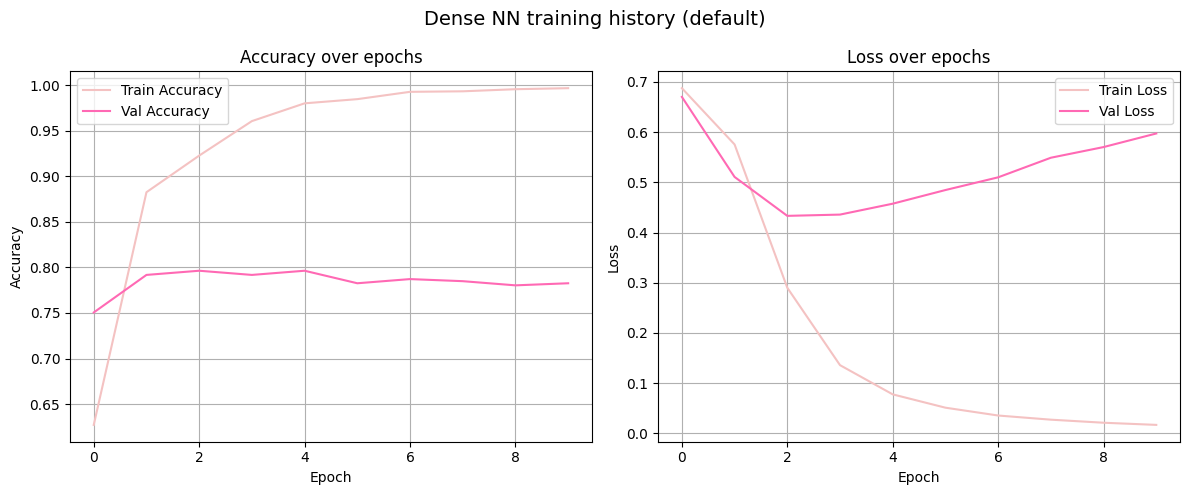

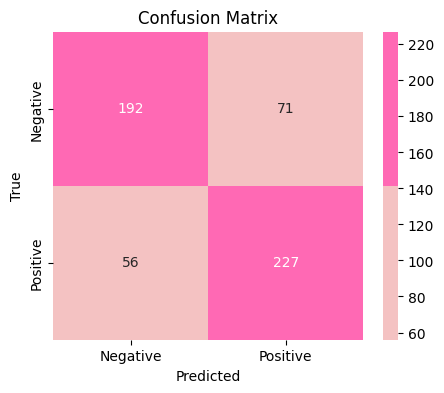

18/18 [==============================] - 0s 4ms/step


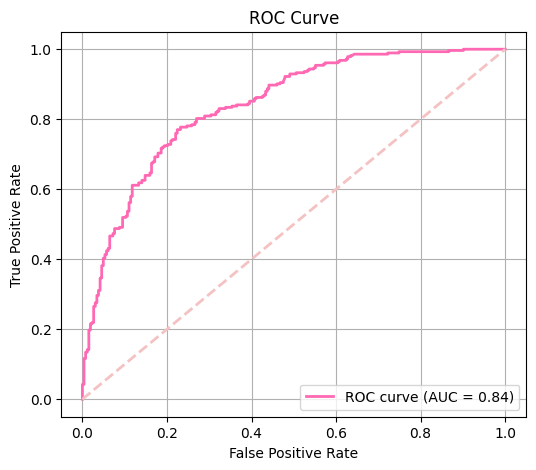

18/18 [==============================] - 0s 4ms/step


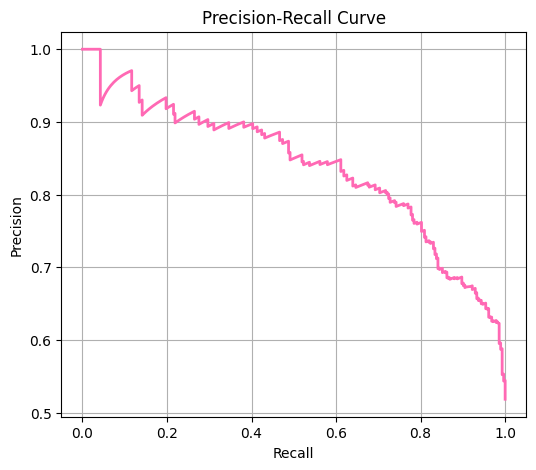

c:\Users\KAROLD\Documents\universidad\s6\discr3\sentiment_analysis\venv_test\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Full model saved at ../outputs/dense_baseline\saved_models\dense_baseline.h5
Weights saved at ../outputs/dense_baseline\saved_models\dense_baseline_weights.h5
Training history saved at ../outputs/dense_baseline\saved_models\dense_baseline_history.pkl
Metrics saved at ../outputs/dense_baseline\metrics\dense_baseline_metrics.txt
Figure saved at: ../outputs/dense_baseline\figures\dense_baseline_training_history.png
Figure saved at: ../outputs/dense_baseline\figures\dense_baseline_confusion_matrix.png
Figure saved at: ../outputs/dense_baseline\figures\dense_baseline_roc_curve.png
Figure saved at: ../outputs/dense_baseline\figures\dense_baseline_precision_recall.png


In [62]:
fig1 = plot_training_history(history_default, "Dense NN training history (default)")
fig2 = plot_confusion_matrix(y_test, y_pred_default)
fig3 = plot_roc_curve(y_test, dense_default.predict(X_test_tfidf))
fig4 = plot_precision_recall(y_test, dense_default.predict(X_test_tfidf))

figures_to_save = [
    (fig1, "dense_baseline_training_history.png"),
    (fig2, "dense_baseline_confusion_matrix.png"),
    (fig3, "dense_baseline_roc_curve.png"),
    (fig4, "dense_baseline_precision_recall.png")
]

save_trained_model(
    dense_default,
    dense_default,
    dense_default_results,
    figures=figures_to_save,
    model_name="dense_baseline",
    base_path="../outputs/dense_baseline"
)

In [ ]:
print("\nTraining dense model (grid search)...")
best_dense, best_history, best_params, best_score = grid_search_dense(
    X_train_tfidf, y_train, X_test_tfidf, y_test, input_dim
)

print(f"Best dense configuration: {best_params}")

dense_results = evaluate_model(best_dense, X_test_tfidf, y_test)
y_pred_dense = (best_dense.predict(X_test_tfidf) > 0.5).astype(int)


Training dense model (grid search)...

Training Dense(64) | lr=0.001 | batch=32 | epochs=5
Epoch 1/5
69/69 [==============================] - 2s 11ms/step - loss: 0.6838 - accuracy: 0.6158 - val_loss: 0.6559 - val_accuracy: 0.7326
Epoch 2/5
69/69 [==============================] - 0s 7ms/step - loss: 0.5040 - accuracy: 0.8670 - val_loss: 0.4748 - val_accuracy: 0.7802
Epoch 3/5
69/69 [==============================] - 1s 9ms/step - loss: 0.2203 - accuracy: 0.9303 - val_loss: 0.4746 - val_accuracy: 0.7912
Epoch 4/5
69/69 [==============================] - 1s 8ms/step - loss: 0.1118 - accuracy: 0.9674 - val_loss: 0.5374 - val_accuracy: 0.7894
Epoch 5/5
69/69 [==============================] - 0s 7ms/step - loss: 0.0682 - accuracy: 0.9830 - val_loss: 0.5930 - val_accuracy: 0.7875
Val Accuracy: 0.7875

Training Dense(64) | lr=0.001 | batch=64 | epochs=5
Epoch 1/5
35/35 [==============================] - 2s 19ms/step - loss: 0.6881 - accuracy: 0.5672 - val_loss: 0.6786 - val_accuracy: 0.675

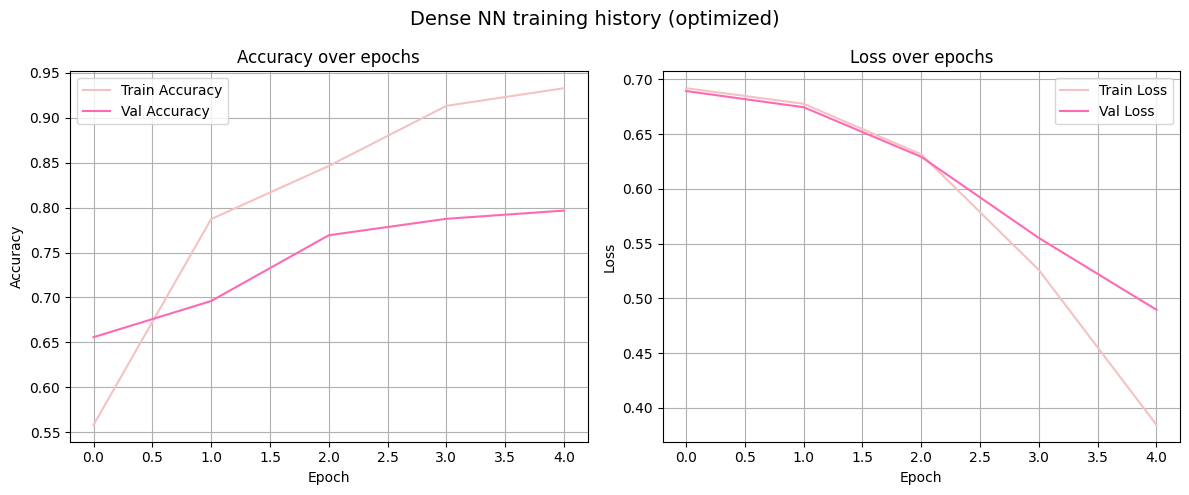

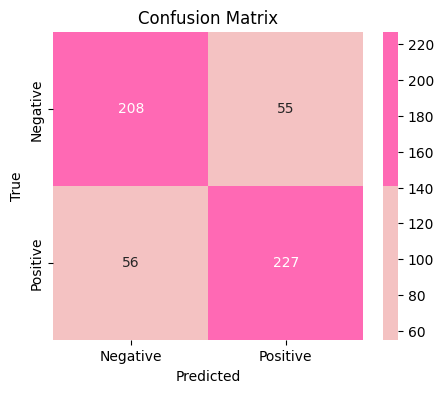

18/18 [==============================] - 0s 4ms/step


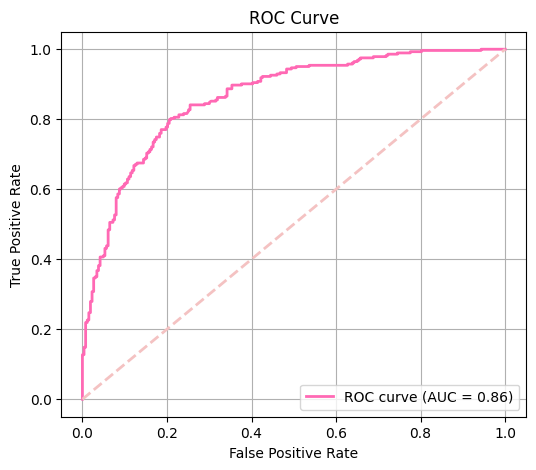

18/18 [==============================] - 0s 4ms/step


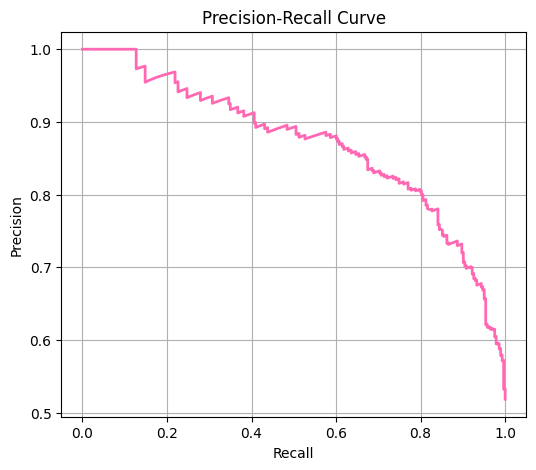

c:\Users\KAROLD\Documents\universidad\s6\discr3\sentiment_analysis\venv_test\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Full model saved at ../outputs/dense_optimized\saved_models\dense_optimized.h5
Weights saved at ../outputs/dense_optimized\saved_models\dense_optimized_weights.h5
Training history saved at ../outputs/dense_optimized\saved_models\dense_optimized_history.pkl
Metrics saved at ../outputs/dense_optimized\metrics\dense_optimized_metrics.txt
Figure saved at: ../outputs/dense_optimized\figures\dense_optimized_training_history.png
Figure saved at: ../outputs/dense_optimized\figures\dense_optimized_confusion_matrix.png
Figure saved at: ../outputs/dense_optimized\figures\dense_optimized_roc_curve.png
Figure saved at: ../outputs/dense_optimized\figures\dense_optimized_precision_recall.png


In [66]:
fig1 = plot_training_history(best_history, "Dense NN training history (optimized)")
fig2 = plot_confusion_matrix(y_test, y_pred_dense)
fig3 = plot_roc_curve(y_test, best_dense.predict(X_test_tfidf))
fig4 = plot_precision_recall(y_test, best_dense.predict(X_test_tfidf))

figures_to_save = [
    (fig1, "dense_optimized_training_history.png"),
    (fig2, "dense_optimized_confusion_matrix.png"),
    (fig3, "dense_optimized_roc_curve.png"),
    (fig4, "dense_optimized_precision_recall.png")
]

save_trained_model(
    best_dense,
    best_history,
    dense_results,
    figures=figures_to_save,
    model_name="dense_optimized",
    base_path="../outputs/dense_optimized"
)

In [67]:
# Comparison of final metrics
results = {
    "Before Opt": dense_default_results,
    "After Opt": dense_results
}
fig = compare_metrics(results)
save_plot(fig, "comparison_metrics.png", base_path="../outputs/dense")

Figure saved at: ../outputs/dense\figures\comparison_metrics.png


## 2. Vanilla RNN

In [ ]:
# Vanilla RNN without optimization
print("\n Training RNN model without optimization...")
rnn_model = build_rnn_model(vocab_size)

rnn_model, history_rnn, _ = train_model(
    rnn_model,
    X_train_pad, y_train,
    X_test_pad,  y_test,
    epochs=5,
    batch_size=32
)

print("\nBase RNN model results:")

rnn_results = evaluate_model(rnn_model, X_test_pad, y_test)

y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype(int)


 Training RNN model without optimization...
Epoch 1/5
69/69 [==============================] - 5s 38ms/step - loss: 0.6747 - accuracy: 0.5873 - val_loss: 0.6304 - val_accuracy: 0.6575
Epoch 2/5
69/69 [==============================] - 2s 35ms/step - loss: 0.3890 - accuracy: 0.8872 - val_loss: 0.5323 - val_accuracy: 0.7363
Epoch 3/5
69/69 [==============================] - 3s 37ms/step - loss: 0.1461 - accuracy: 0.9574 - val_loss: 0.5641 - val_accuracy: 0.7473
Epoch 4/5
69/69 [==============================] - 2s 36ms/step - loss: 0.0719 - accuracy: 0.9817 - val_loss: 0.5817 - val_accuracy: 0.7454
Epoch 5/5
69/69 [==============================] - 3s 36ms/step - loss: 0.0401 - accuracy: 0.9885 - val_loss: 0.7024 - val_accuracy: 0.7418

Base RNN model results:
18/18 [==============================] - 1s 8ms/step
=== Evaluation Metrics ===
Accuracy : 0.7418
Precision: 0.7040
Recall   : 0.8657
F1-score : 0.7765
Cohen’s Kappa: 0.4783

Classification Report:
               precision    reca

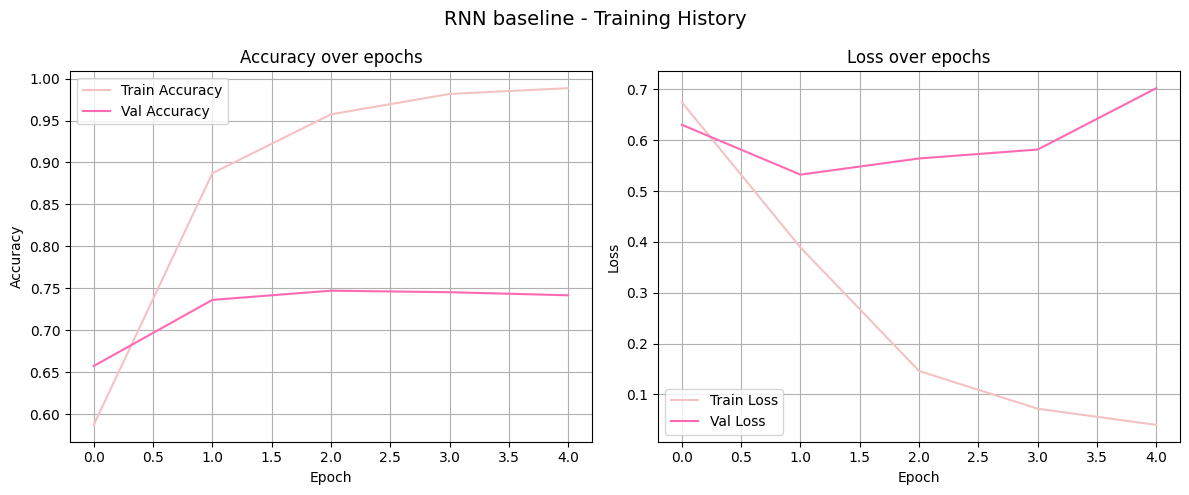

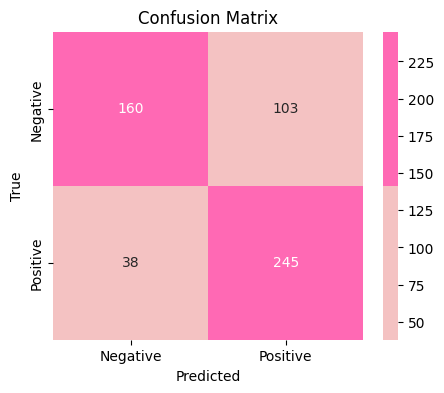

18/18 [==============================] - 0s 9ms/step


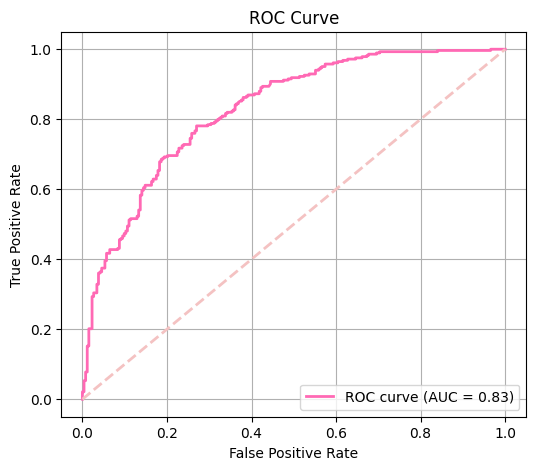

18/18 [==============================] - 0s 8ms/step


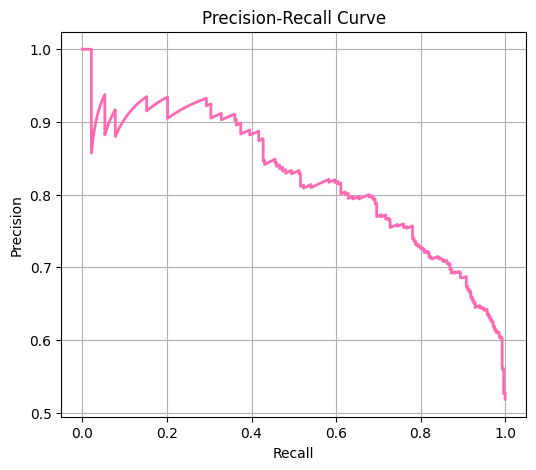

c:\Users\KAROLD\Documents\universidad\s6\discr3\sentiment_analysis\venv_test\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Full model saved at ../outputs/rnn_baseline\saved_models\rnn_baseline.h5
Weights saved at ../outputs/rnn_baseline\saved_models\rnn_baseline_weights.h5
Training history saved at ../outputs/rnn_baseline\saved_models\rnn_baseline_history.pkl
Metrics saved at ../outputs/rnn_baseline\metrics\rnn_baseline_metrics.txt
Figure saved at: ../outputs/rnn_baseline\figures\rnn_baseline_training_history.png
Figure saved at: ../outputs/rnn_baseline\figures\rnn_baseline_confusion_matrix.png
Figure saved at: ../outputs/rnn_baseline\figures\rnn_baseline_roc_curve.png
Figure saved at: ../outputs/rnn_baseline\figures\rnn_baseline_precision_recall.png


In [60]:
fig1 = plot_training_history(history_rnn, "RNN baseline - Training History")
fig2 = plot_confusion_matrix(y_test, y_pred_rnn)
fig3 = plot_roc_curve(y_test, rnn_model.predict(X_test_pad))
fig4 = plot_precision_recall(y_test, rnn_model.predict(X_test_pad))

figures_to_save = [
    (fig1, "rnn_baseline_training_history.png"),
    (fig2, "rnn_baseline_confusion_matrix.png"),
    (fig3, "rnn_baseline_roc_curve.png"),
    (fig4, "rnn_baseline_precision_recall.png")
]

save_trained_model(
    rnn_model,
    history_rnn,
    rnn_results,
    figures=figures_to_save,
    model_name="rnn_baseline",
    base_path="../outputs/rnn_baseline"
)



Starting Bayesian Optimization (EI) for RNN...

 Testing RNN: emb=259, units=99, lr=0.002112, batch=89
Epoch 1/10
25/25 [==============================] - 5s 92ms/step - loss: 0.6793 - accuracy: 0.5603 - val_loss: 0.6271 - val_accuracy: 0.6758
Epoch 2/10
25/25 [==============================] - 2s 67ms/step - loss: 0.2690 - accuracy: 0.9386 - val_loss: 0.6245 - val_accuracy: 0.6886
Epoch 3/10
25/25 [==============================] - 2s 67ms/step - loss: 0.1120 - accuracy: 0.9624 - val_loss: 0.7590 - val_accuracy: 0.6832
Epoch 4/10
25/25 [==============================] - 2s 69ms/step - loss: 0.0424 - accuracy: 0.9858 - val_loss: 0.8523 - val_accuracy: 0.6832
Epoch 5/10
25/25 [==============================] - 2s 70ms/step - loss: 0.0260 - accuracy: 0.9904 - val_loss: 0.9363 - val_accuracy: 0.6978
Epoch 6/10
25/25 [==============================] - 2s 67ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 1.0054 - val_accuracy: 0.6813
Epoch 7/10
25/25 [==============================]

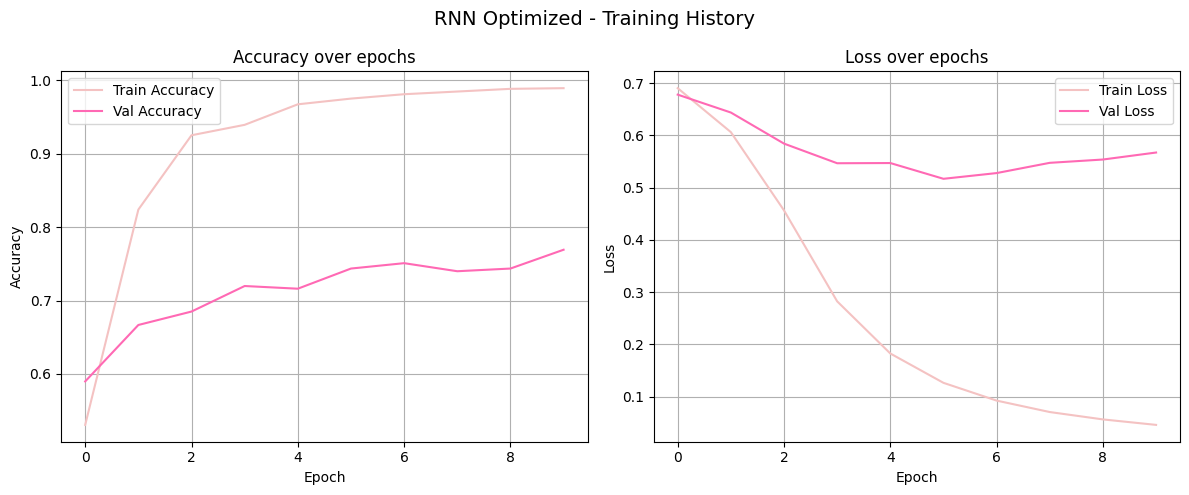

18/18 [==============================] - 1s 12ms/step
=== Evaluation Metrics ===
Accuracy : 0.7692
Precision: 0.7716
Recall   : 0.7880
F1-score : 0.7797
Cohen’s Kappa: 0.5375

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       263
           1       0.77      0.79      0.78       283

    accuracy                           0.77       546
   macro avg       0.77      0.77      0.77       546
weighted avg       0.77      0.77      0.77       546

18/18 [==============================] - 0s 11ms/step


In [47]:
#   Phase 2: Training with EI optimization
print("\n\nStarting Bayesian Optimization (EI) for RNN...")

best_rnn_model, best_rnn_history, best_rnn_params, best_rnn_score = bayes_opt_rnn(
    X_train_pad, y_train,
    X_test_pad,  y_test,
    vocab_size=vocab_size
)

print("\nBest RNN model found (Bayesian Optimization):")
print(best_rnn_params)
print(f"Best Validation Accuracy: {best_rnn_score:.4f}")

# Results of the optimized model
print("\nOptimized RNN model results:")
plot_training_history(best_rnn_history, "RNN Optimized - Training History")

rnn_opt_results = evaluate_model(best_rnn_model, X_test_pad, y_test)

y_pred_rnn_opt = (best_rnn_model.predict(X_test_pad) > 0.5).astype(int)

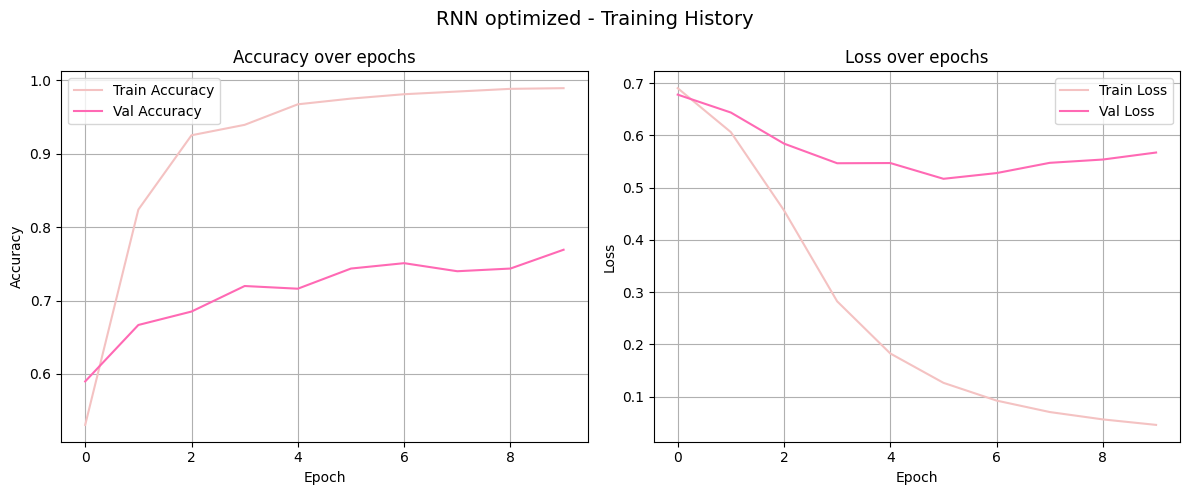

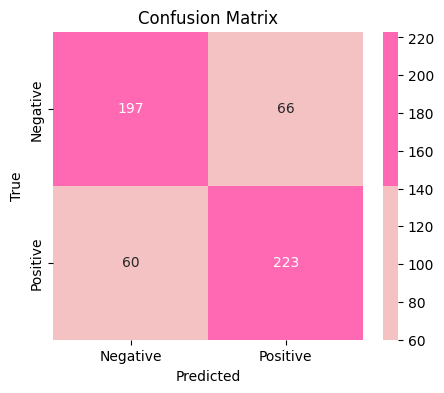

18/18 [==============================] - 0s 11ms/step


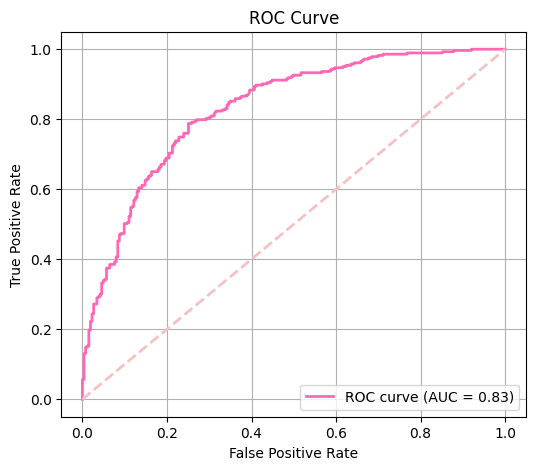

18/18 [==============================] - 0s 11ms/step


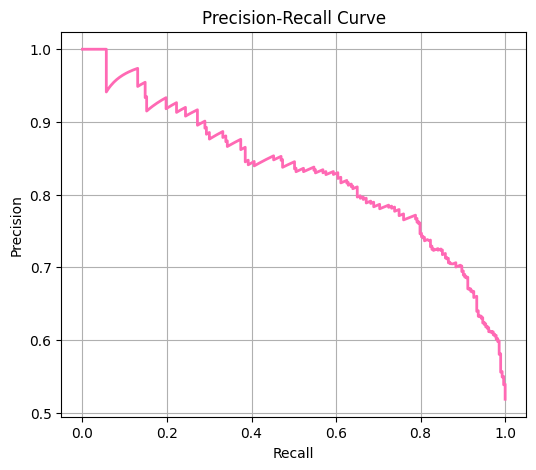

c:\Users\KAROLD\Documents\universidad\s6\discr3\sentiment_analysis\venv_test\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Full model saved at ../outputs/rnn_optimized\saved_models\rnn_optimized.h5
Weights saved at ../outputs/rnn_optimized\saved_models\rnn_optimized_weights.h5
Training history saved at ../outputs/rnn_optimized\saved_models\rnn_optimized_history.pkl
Metrics saved at ../outputs/rnn_optimized\metrics\rnn_optimized_metrics.txt
Figure saved at: ../outputs/rnn_optimized\figures\rnn_optimized_training_history.png
Figure saved at: ../outputs/rnn_optimized\figures\rnn_optimized_confusion_matrix.png
Figure saved at: ../outputs/rnn_optimized\figures\rnn_optimized_roc_curve.png
Figure saved at: ../outputs/rnn_optimized\figures\rnn_optimized_precision_recall.png


In [49]:
fig1 = plot_training_history(best_rnn_history, "RNN optimized - Training History")
fig2 = plot_confusion_matrix(y_test, y_pred_rnn_opt)
fig3 = plot_roc_curve(y_test, best_rnn_model.predict(X_test_pad))
fig4 = plot_precision_recall(y_test, best_rnn_model.predict(X_test_pad))

figures_to_save = [
    (fig1, "rnn_optimized_training_history.png"),
    (fig2, "rnn_optimized_confusion_matrix.png"),
    (fig3, "rnn_optimized_roc_curve.png"),
    (fig4, "rnn_optimized_precision_recall.png")
]

save_trained_model(
    best_rnn_model,
    best_rnn_model,
    rnn_opt_results,
    figures=figures_to_save,
    model_name="rnn_optimized",
    base_path="../outputs/rnn_optimized"
)

In [52]:
# Comparison of final metrics
results = {
    "Before Opt": rnn_results,
    "After Opt": rnn_opt_results
}
fig = compare_metrics(results)

save_plot(fig, "comparison_metrics.png", base_path="../outputs/rnn")

Figure saved at: ../outputs/rnn\figures\comparison_metrics.png


## 3. LSTM

In [33]:
# 1. LSTM without optimization
print("\n Training LSTM baseline model...")
lstm_baseline = build_lstm_model(vocab_size)

lstm_baseline, history_lstm_base, _ = train_model(
    lstm_baseline,
    X_train_pad, y_train,
    X_test_pad, y_test,
    epochs=5,
    batch_size=32
)

print("\nEvaluating baseline model...")
lstm_results = evaluate_model(lstm_baseline, X_test_pad, y_test)

# Baseline predictions
y_pred_lstm_base = (lstm_baseline.predict(X_test_pad) > 0.5).astype(int)


 Training LSTM baseline model...
Epoch 1/5
69/69 [==============================] - 11s 90ms/step - loss: 0.6745 - accuracy: 0.5883 - val_loss: 0.5958 - val_accuracy: 0.7546
Epoch 2/5
69/69 [==============================] - 5s 72ms/step - loss: 0.4910 - accuracy: 0.8061 - val_loss: 0.4937 - val_accuracy: 0.7747
Epoch 3/5
69/69 [==============================] - 4s 65ms/step - loss: 0.2638 - accuracy: 0.9010 - val_loss: 0.4737 - val_accuracy: 0.7912
Epoch 4/5
69/69 [==============================] - 5s 78ms/step - loss: 0.1530 - accuracy: 0.9523 - val_loss: 0.4985 - val_accuracy: 0.7967
Epoch 5/5
69/69 [==============================] - 4s 65ms/step - loss: 0.1211 - accuracy: 0.9610 - val_loss: 0.5721 - val_accuracy: 0.7930

Evaluating baseline model...
18/18 [==============================] - 1s 24ms/step
=== Evaluation Metrics ===
Accuracy : 0.7930
Precision: 0.7911
Recall   : 0.8163
F1-score : 0.8035
Cohen’s Kappa: 0.5850

Classification Report:
               precision    recall  

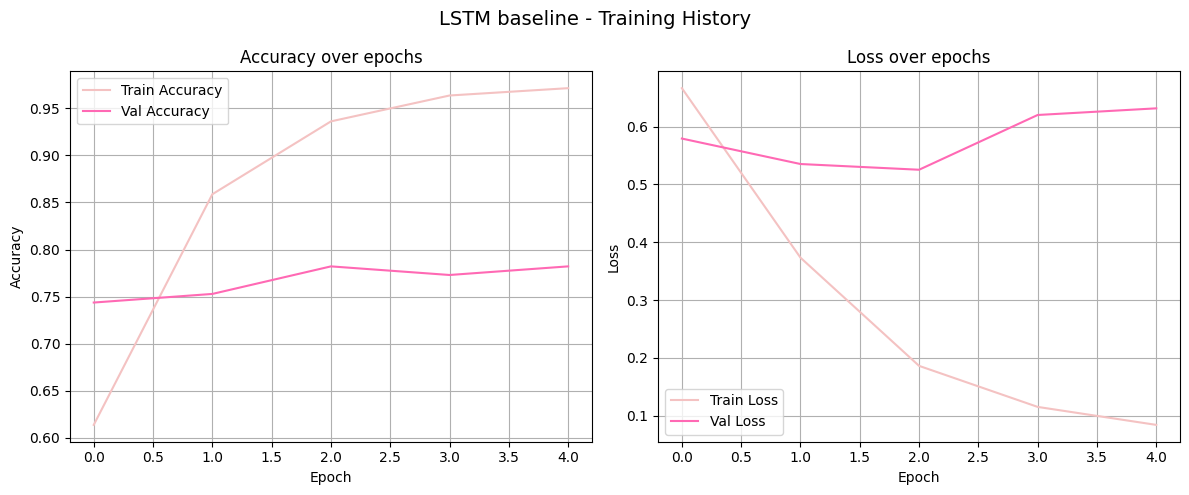

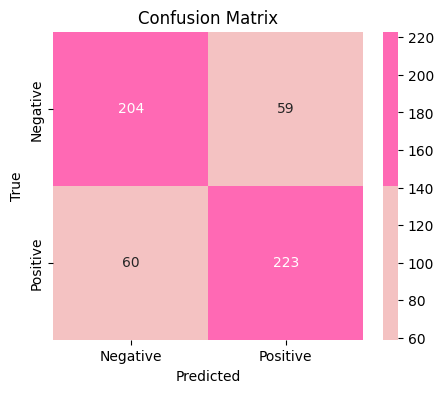

18/18 [==============================] - 0s 23ms/step


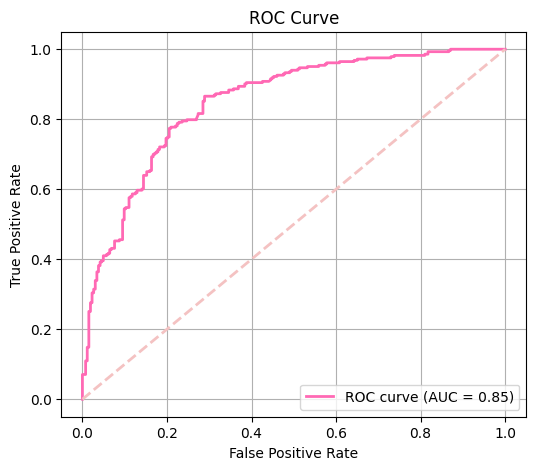

18/18 [==============================] - 0s 22ms/step


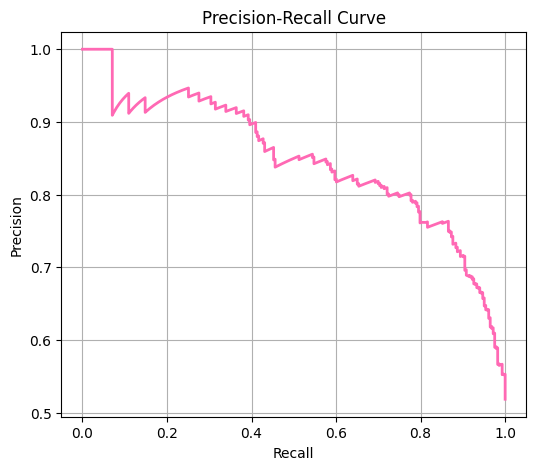

c:\Users\KAROLD\Documents\universidad\s6\discr3\sentiment_analysis\venv_test\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Full model saved at ../outputs/lstm_baseline\saved_models\lstm_baseline.h5
Weights saved at ../outputs/lstm_baseline\saved_models\lstm_baseline_weights.h5
Training history saved at ../outputs/lstm_baseline\saved_models\lstm_baseline_history.pkl
Metrics saved at ../outputs/lstm_baseline\metrics\lstm_baseline_metrics.txt
Figure saved at: ../outputs/lstm_baseline\figures\lstm_baseline_training_history.png
Figure saved at: ../outputs/lstm_baseline\figures\lstm_baseline_confusion_matrix.png
Figure saved at: ../outputs/lstm_baseline\figures\lstm_baseline_roc_curve.png
Figure saved at: ../outputs/lstm_baseline\figures\lstm_baseline_precision_recall.png


In [32]:
fig1 = plot_training_history(history_lstm_base, "LSTM baseline - Training History")
fig2 = plot_confusion_matrix(y_test, y_pred_lstm_base)
fig3 = plot_roc_curve(y_test, lstm_baseline.predict(X_test_pad))
fig4 = plot_precision_recall(y_test, lstm_baseline.predict(X_test_pad))

figures_to_save = [
    (fig1, "lstm_baseline_training_history.png"),
    (fig2, "lstm_baseline_confusion_matrix.png"),
    (fig3, "lstm_baseline_roc_curve.png"),
    (fig4, "lstm_baseline_precision_recall.png")
]

save_trained_model(
    lstm_baseline,
    lstm_baseline,
    lstm_results,
    figures=figures_to_save,
    model_name="lstm_baseline",
    base_path="../outputs/lstm_baseline"
)



Starting Bayesian Optimization (EI) for LSTM...

 Testing LSTM: emb=259, units=99, lr=0.002112, batch=89
Epoch 1/10
25/25 [==============================] - 11s 279ms/step - loss: 0.6454 - accuracy: 0.6534 - val_loss: 0.5176 - val_accuracy: 0.7619
Epoch 2/10
25/25 [==============================] - 5s 187ms/step - loss: 0.2865 - accuracy: 0.8890 - val_loss: 0.5101 - val_accuracy: 0.7802
Epoch 3/10
25/25 [==============================] - 5s 194ms/step - loss: 0.1370 - accuracy: 0.9555 - val_loss: 0.5330 - val_accuracy: 0.7747
Epoch 4/10
25/25 [==============================] - 4s 181ms/step - loss: 0.1055 - accuracy: 0.9707 - val_loss: 0.7420 - val_accuracy: 0.7601
Epoch 5/10
25/25 [==============================] - 5s 187ms/step - loss: 0.0617 - accuracy: 0.9766 - val_loss: 0.8327 - val_accuracy: 0.7564
Epoch 6/10
25/25 [==============================] - 5s 186ms/step - loss: 0.0449 - accuracy: 0.9849 - val_loss: 0.9617 - val_accuracy: 0.7509
Epoch 7/10
25/25 [======================

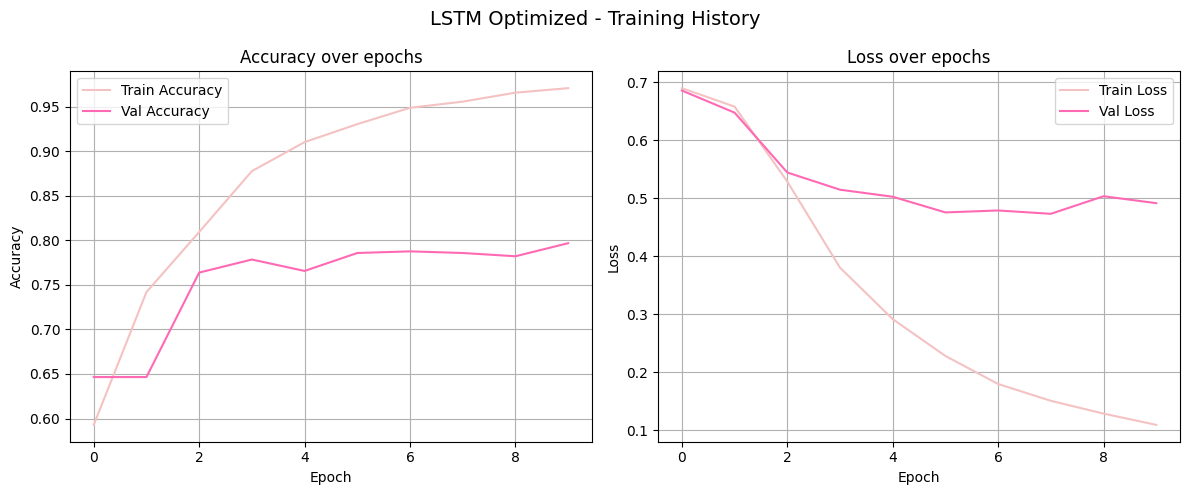

18/18 [==============================] - 1s 19ms/step
=== Evaluation Metrics ===
Accuracy : 0.7967
Precision: 0.8007
Recall   : 0.8092
F1-score : 0.8049
Cohen’s Kappa: 0.5927

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79       263
           1       0.80      0.81      0.80       283

    accuracy                           0.80       546
   macro avg       0.80      0.80      0.80       546
weighted avg       0.80      0.80      0.80       546

18/18 [==============================] - 0s 20ms/step


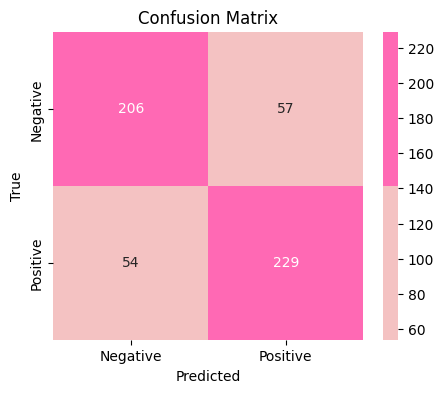

18/18 [==============================] - 0s 19ms/step


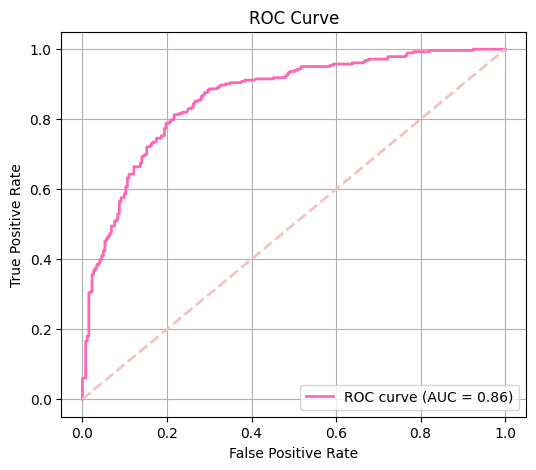

18/18 [==============================] - 0s 20ms/step


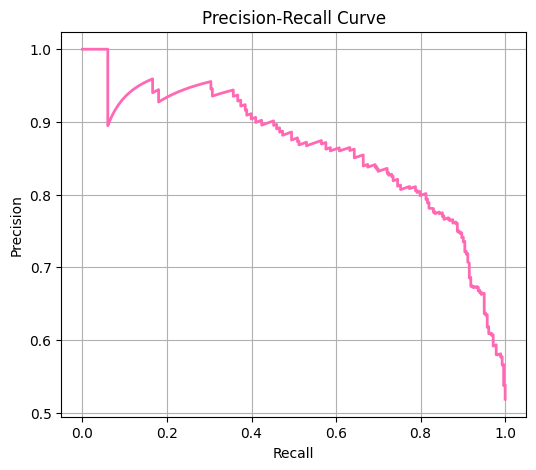

In [ ]:
#   Phase 2: Training with EI optimization
print("\n\nStarting Bayesian Optimization (EI) for LSTM...")

best_lstm_model, best_lstm_history, best_lstm_params, best_lstm_score = bayes_opt_lstm(
    X_train_pad, y_train,
    X_test_pad,  y_test,
    vocab_size=vocab_size
)

print("\nBest LSTM model found (Bayesian Optimization):")
print(best_lstm_params)
print(f"Best Validation Accuracy: {best_lstm_score:.4f}")

# Results of the optimized model
print("\nOptimized LSTM model results:")
plot_training_history(best_lstm_history, "LSTM Optimized - Training History")

lstm_opt_results = evaluate_model(best_lstm_model, X_test_pad, y_test)

y_pred_lstm_opt = (best_lstm_model.predict(X_test_pad) > 0.5).astype(int)

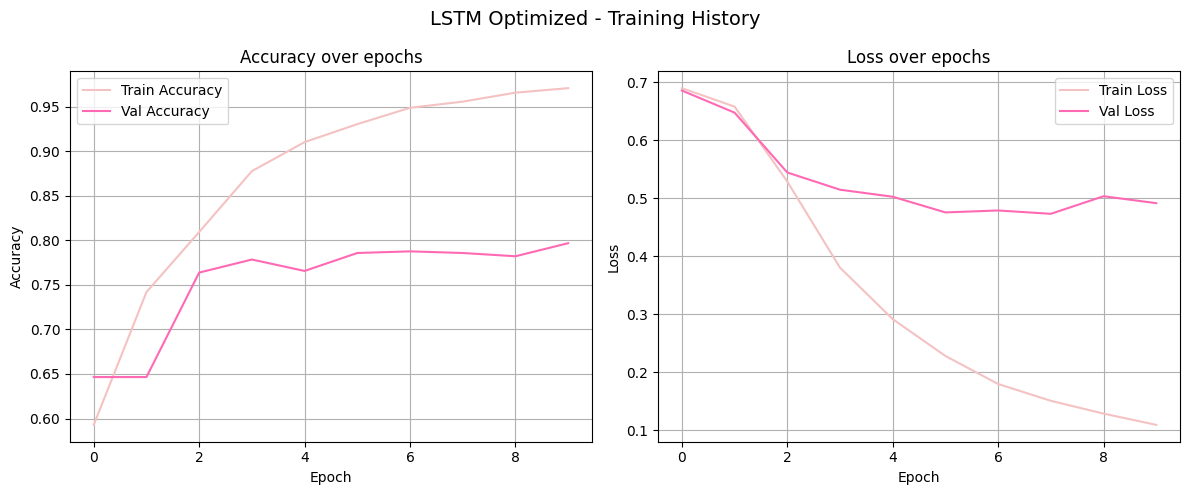

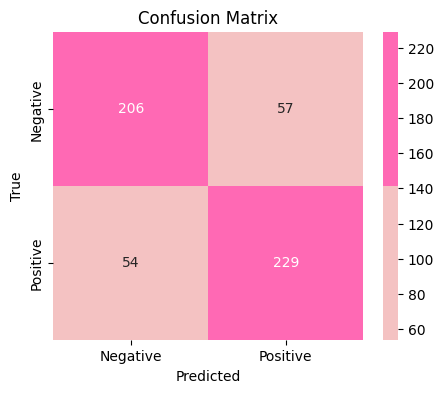

18/18 [==============================] - 0s 20ms/step


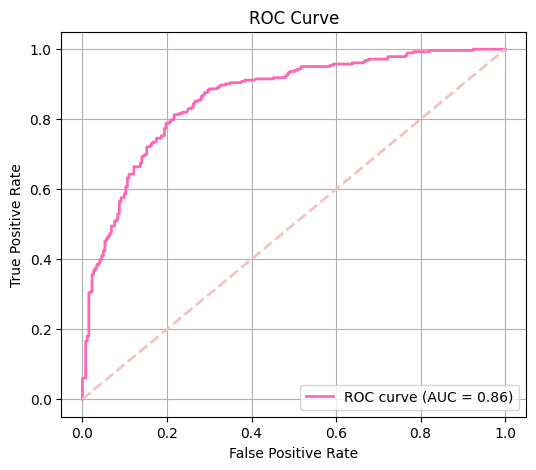

18/18 [==============================] - 1s 28ms/step


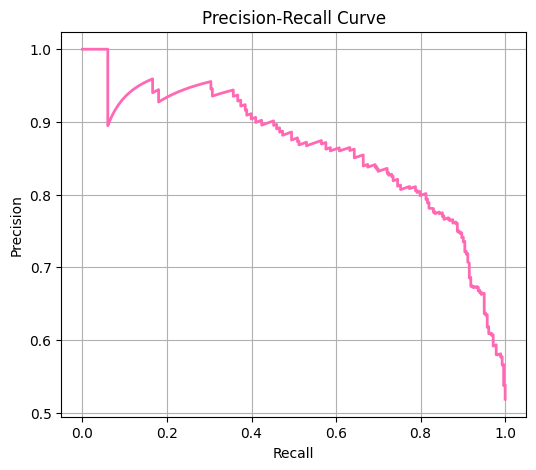

c:\Users\KAROLD\Documents\universidad\s6\discr3\sentiment_analysis\venv_test\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Full model saved at ../outputs/lstm_optimized\saved_models\lstm_optimized.h5
Weights saved at ../outputs/lstm_optimized\saved_models\lstm_optimized_weights.h5
Training history saved at ../outputs/lstm_optimized\saved_models\lstm_optimized_history.pkl
Metrics saved at ../outputs/lstm_optimized\metrics\lstm_optimized_metrics.txt
Figure saved at: ../outputs/lstm_optimized\figures\lstm_optimized_training_history.png
Figure saved at: ../outputs/lstm_optimized\figures\lstm_optimized_confusion_matrix.png
Figure saved at: ../outputs/lstm_optimized\figures\lstm_optimized_roc_curve.png
Figure saved at: ../outputs/lstm_optimized\figures\lstm_optimized_precision_recall.png


In [34]:
fig1 = plot_training_history(best_lstm_history, "LSTM Optimized - Training History")
fig2 = plot_confusion_matrix(y_test, y_pred_lstm_opt)
fig3 = plot_roc_curve(y_test, best_lstm_model.predict(X_test_pad))
fig4 = plot_precision_recall(y_test, best_lstm_model.predict(X_test_pad))

figures_to_save = [
    (fig1, "lstm_optimized_training_history.png"),
    (fig2, "lstm_optimized_confusion_matrix.png"),
    (fig3, "lstm_optimized_roc_curve.png"),
    (fig4, "lstm_optimized_precision_recall.png")
]

save_trained_model(
    best_lstm_model,
    best_lstm_history,
    lstm_opt_results,
    figures=figures_to_save,
    model_name="lstm_optimized",
    base_path="../outputs/lstm_optimized"
)

In [ ]:
# Comparison of final metrics
results = {
    "Before Opt": lstm_results,
    "After Opt": lstm_opt_results
}
fig = compare_metrics(results)

save_plot(fig, "comparison_metrics.png", base_path="../outputs/lstm")

Figure saved at: ../outputs/lstm\figures\comparison_metrics.png


## Final comparison of all models

In [68]:
print("\n Comparing results...")
results_dict = {
    "Dense NN": dense_default_results,
    "RNN": rnn_results,
    "LSTM": lstm_results
}

fig1 = compare_metrics(results_dict)
save_plot(fig1, "comparison_metrics_wo_opt.png", base_path="../outputs/comparison")

results_dict = {
    "Dense NN": dense_results,
    "RNN": rnn_opt_results,
    "LSTM": lstm_opt_results
}

fig2 = compare_metrics(results_dict)
save_plot(fig2, "comparison_metrics_optimized.png", base_path="../outputs/comparison")

print("Training and evaluation completed.")



 Comparing results...
Figure saved at: ../outputs/comparison\figures\comparison_metrics_wo_opt.png
Figure saved at: ../outputs/comparison\figures\comparison_metrics_optimized.png
Training and evaluation completed.
